# Forecast Shipment by Product Group

In [645]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
import pmdarima as pm
import time

from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()

In [412]:
# Import data
shipments_df = pd.read_csv('./data/shipped_product_month.csv', index_col='ship_date', parse_dates=True)
shipments_df.head()

,Billets,MBQ,Rebar,SBQ
ship_date,,,,
2008-04-01,3.801767,56.900843,38.925538,NaN
2008-05-01,0.826908,49.500034,34.079521,NaN
2008-06-01,2.511280,54.893877,28.150001,NaN
2008-07-01,NaN,64.217632,33.609220,0.082428
2008-08-01,NaN,51.486967,19.292416,NaN


In [413]:
shipments_df.tail()

,Billets,MBQ,Rebar,SBQ
ship_date,,,,
2019-08-01,12.253267,36.462538,33.518796,7.837487
2019-09-01,20.969158,44.293856,39.221265,9.260255
2019-10-01,12.046338,38.181721,31.752206,5.080688
2019-11-01,24.153596,40.059269,25.216461,10.096839
2019-12-01,15.716298,39.272628,27.310011,5.357499


## Inspection and Analysis

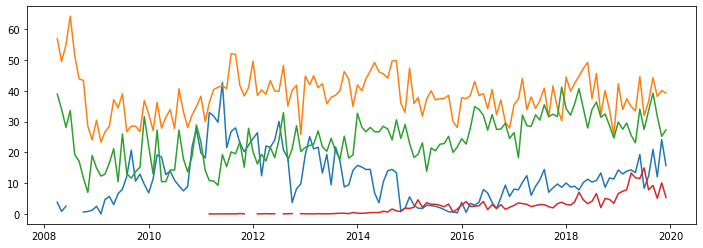

In [414]:
fig = plt.figure(figsize=(12, 4))
plt.plot(shipments_df)
plt.show()

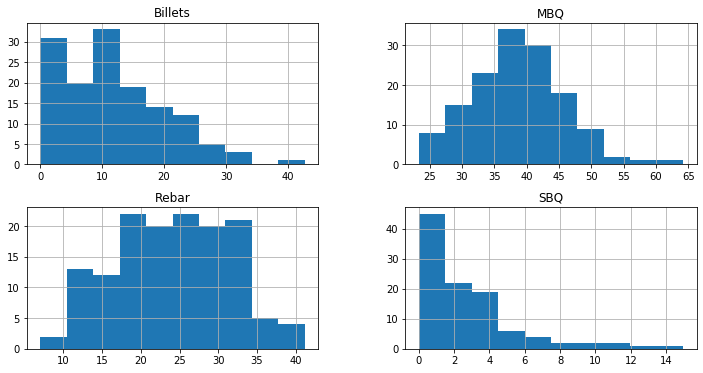

In [415]:
_ = shipments_df.hist(figsize=(12, 6))

In [416]:
# fill missing values with zero
shipments_df = shipments_df.fillna(0)

In [449]:
# create a total column
shipments_df['total'] = shipments_df['MBQ'] + shipments_df['SBQ'] + shipments_df['Rebar'] + shipments_df['Billets']
shipments_df.tail()

,Billets,MBQ,Rebar,SBQ,total
ship_date,,,,,
2019-08-01,12.253267,36.462538,33.518796,7.837487,90.072088
2019-09-01,20.969158,44.293856,39.221265,9.260255,113.744535
2019-10-01,12.046338,38.181721,31.752206,5.080688,87.060954
2019-11-01,24.153596,40.059269,25.216461,10.096839,99.526165
2019-12-01,15.716298,39.272628,27.310011,5.357499,87.656436


In [450]:
decomposition_dict = { }
for col in shipments_df.columns:
    decomposition_dict[col] = sm.tsa.seasonal_decompose(shipments_df[col], model='additive')

Billets


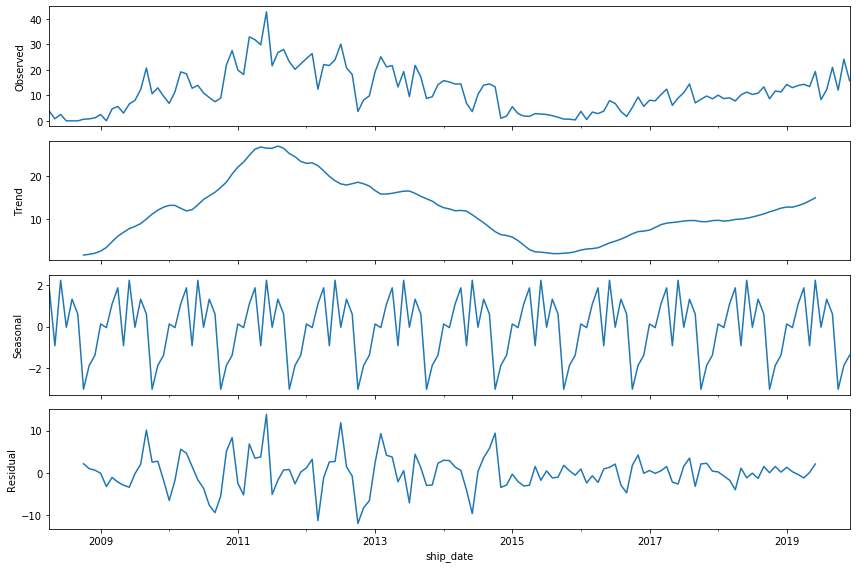

MBQ


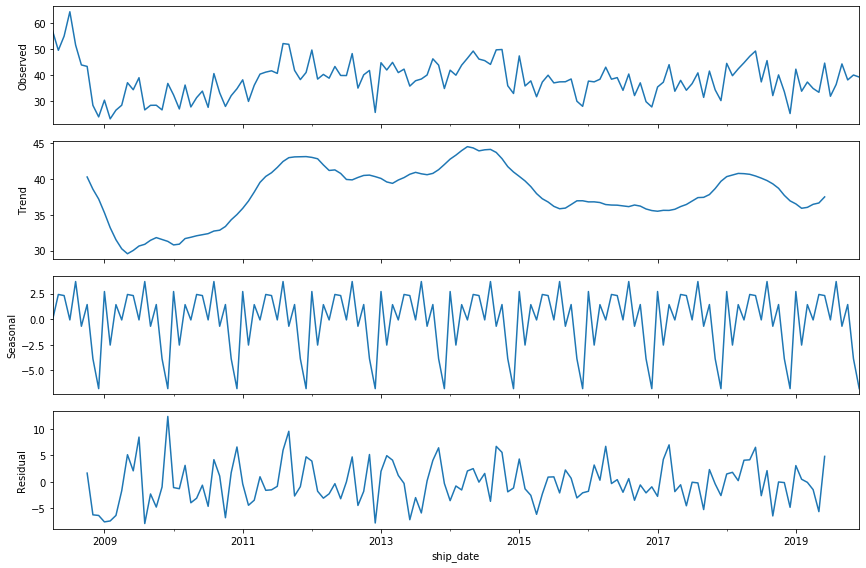

Rebar


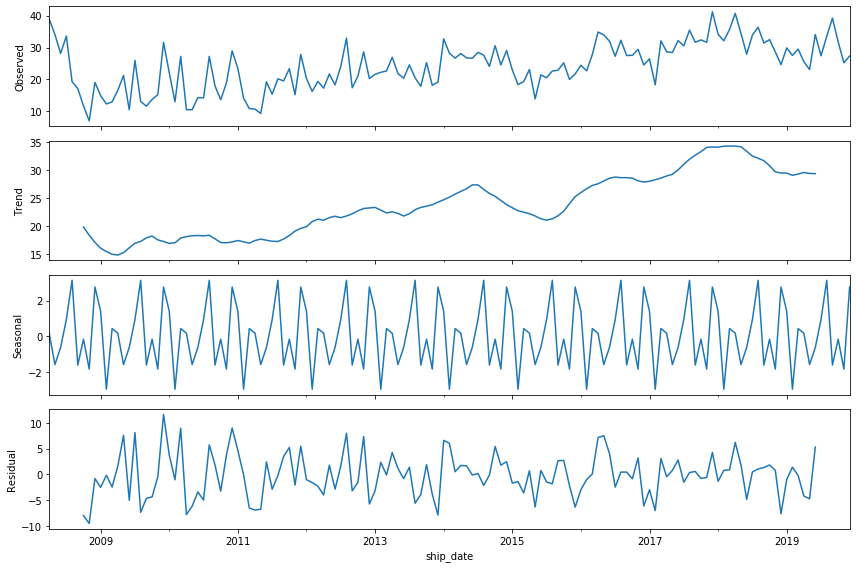

SBQ


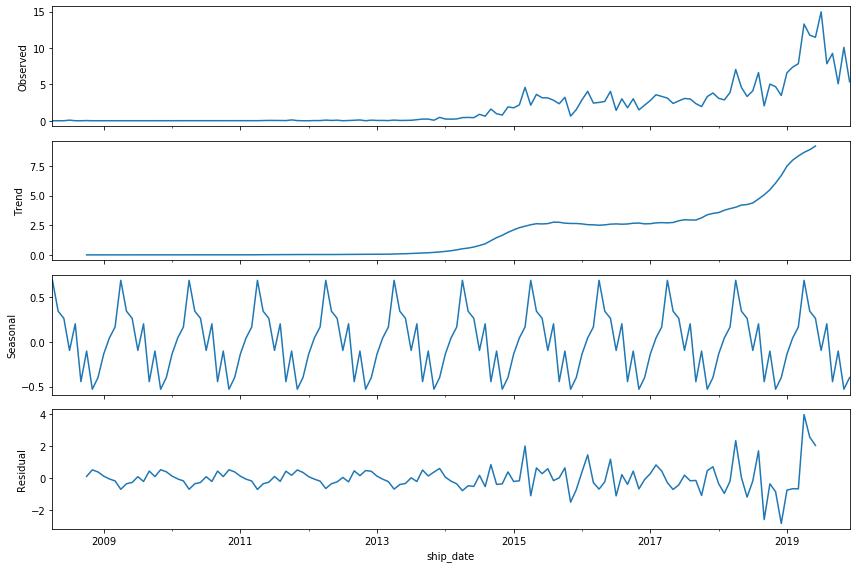

total


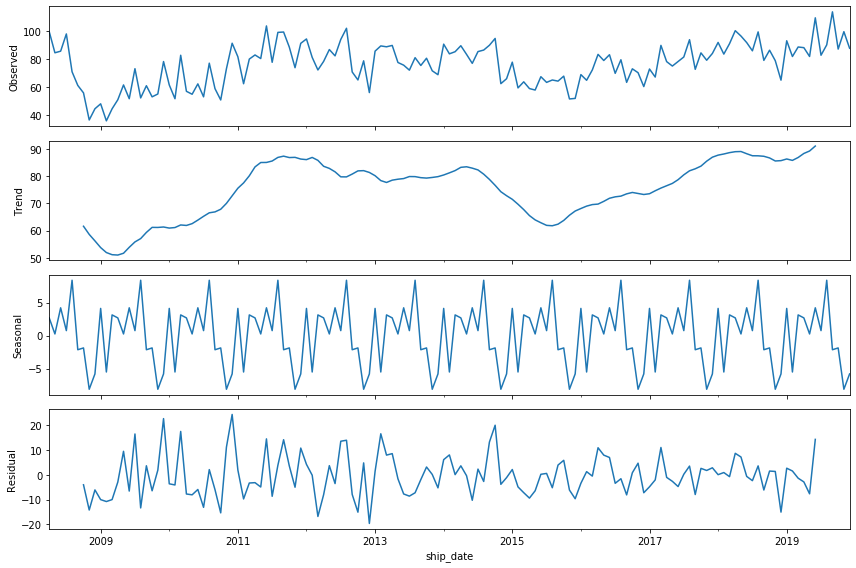

In [451]:
plt.rc('figure',figsize=(12,8))
for d in decomposition_dict:
    print(d)
    decomposition_dict[d].plot()
    plt.show()

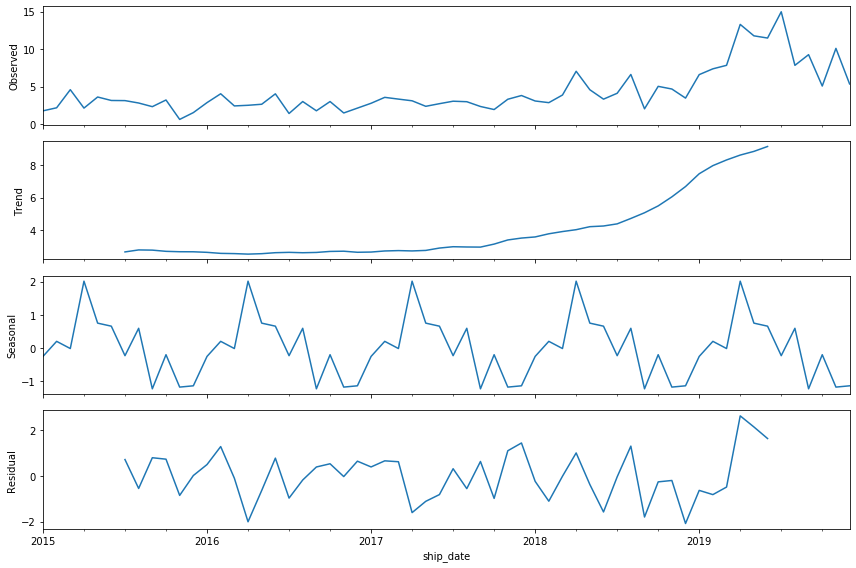

In [419]:
start_date = pd.to_datetime('2015-01-01')
decomposition = sm.tsa.seasonal_decompose(shipments_df.loc[start_date:]['SBQ'], model='additive')
fig = decomposition.plot()
plt.show()

## Model

In [651]:
# create train data
train_start = pd.to_datetime('2015-01-01')
train_end = pd.to_datetime('2018-12-01')
train_df = pd.DataFrame()
train_df["MBQ"] = shipments_df['MBQ'].loc[:train_end]
train_df["Rebar"] = shipments_df['Rebar'].loc[:train_end]
train_df["Billets"] = shipments_df['Billets'].loc[:train_end]
train_df["Billets2015"] = shipments_df['Billets'].loc[train_start:train_end]
train_df["SBQ"] = shipments_df['SBQ'].loc[:train_end]
train_df["SBQ2015"] = shipments_df['SBQ'].loc[train_start:train_end]
train_df["total"] = shipments_df['total'].loc[:train_end]
train_df["total2013"] = shipments_df['total'].loc[pd.to_datetime('2013-01-01'):train_end]

In [652]:
# show train data
print(train_df.head())
print(train_df.tail())

                  MBQ      Rebar   Billets  Billets2015       SBQ  SBQ2015      total  total2013
ship_date                                                                                       
2008-04-01  56.900843  38.925538  3.801767          NaN  0.000000      NaN  99.628147        NaN
2008-05-01  49.500034  34.079521  0.826908          NaN  0.000000      NaN  84.406462        NaN
2008-06-01  54.893877  28.150001  2.511280          NaN  0.000000      NaN  85.555158        NaN
2008-07-01  64.217632  33.609220  0.000000          NaN  0.082428      NaN  97.909280        NaN
2008-08-01  51.486967  19.292416  0.000000          NaN  0.000000      NaN  70.779382        NaN
                  MBQ      Rebar    Billets  Billets2015       SBQ   SBQ2015      total  total2013
ship_date                                                                                         
2018-08-01  45.558115  36.347138  10.843230    10.843230  6.622724  6.622724  99.371207  99.371207
2018-09-01  32.190309  3

In [653]:
# create test data
test_start = pd.to_datetime('2019-01-01')
test_df = shipments_df.loc[test_start:].copy()
test_df['Billets2015'] = test_df['Billets']
test_df['SBQ2015'] = test_df['SBQ']
test_df['total2013'] = test_df['total']
test_df

,Billets,MBQ,Rebar,SBQ,total,Billets2015,SBQ2015,total2013
ship_date,,,,,,,,
2019-01-01,14.250438,42.290188,29.877999,6.601487,93.020112,14.250438,6.601487,93.020112
2019-02-01,12.999956,33.868910,27.503434,7.373235,81.745537,12.999956,7.373235,81.745537
2019-03-01,13.856726,37.364490,29.493135,7.839458,88.553809,13.856726,7.839458,88.553809
2019-04-01,14.310313,34.915783,25.559352,13.289219,88.074667,14.310313,13.289219,88.074667
2019-05-01,13.434216,33.451369,23.101403,11.768810,81.755797,13.434216,11.768810,81.755797
2019-06-01,19.327234,44.601936,34.063120,11.473382,109.465671,19.327234,11.473382,109.465671
2019-07-01,8.321603,31.943244,27.411842,14.971852,82.648541,8.321603,14.971852,82.648541
2019-08-01,12.253267,36.462538,33.518796,7.837487,90.072088,12.253267,7.837487,90.072088
2019-09-01,20.969158,44.293856,39.221265,9.260255,113.744535,20.969158,9.260255,113.744535


In [731]:
# train models (takes a few minutes)
start = time.time()
model_dict = { }
for col in ['total']:
    model_dict[col] = pm.auto_arima(train_df[col].dropna(), m=12, seasonal=True, d=None, D=1,
                                    suppress_warnings=True, error_action='ignore', trace=True,
                                    max_p=2, max_d=2, max_q=2)
    
elapsed = time.time() - start
print('Took %f seconds' % elapsed)
print('Model count: %d' % len(model_dict))

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 1, 12); AIC=921.398, BIC=943.496, Fit time=1.709 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=1005.661, BIC=1011.186, Fit time=0.033 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=947.000, BIC=958.049, Fit time=0.295 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=946.777, BIC=957.825, Fit time=0.379 seconds
Near non-invertible roots for order (0, 0, 1)(0, 1, 1, 12); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=1005.914, BIC=1008.677, Fit time=0.012 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 1, 1, 12); AIC=921.448, BIC=940.784, Fit time=0.915 seconds
Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 1, 0, 12); AIC=941.502, BIC=960.837, Fit time=1.412 seconds
Near non-invertible roots for order (2, 0, 2)(1, 1, 0, 12); setting score to inf (at least one 

In [732]:
# Show model summaries
for model in model_dict:
    print(model)
    print(model_dict[model].summary())
    print()

total
                                 Statespace Model Results                                 
Dep. Variable:                                  y   No. Observations:                  129
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -453.922
Date:                            Thu, 09 Jan 2020   AIC                            919.843
Time:                                    15:42:32   BIC                            936.416
Sample:                                         0   HQIC                           926.572
                                            - 129                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0743      0.212      0.351      0.725      -0.341       0.489
ar.L1          0.8785      0.

total


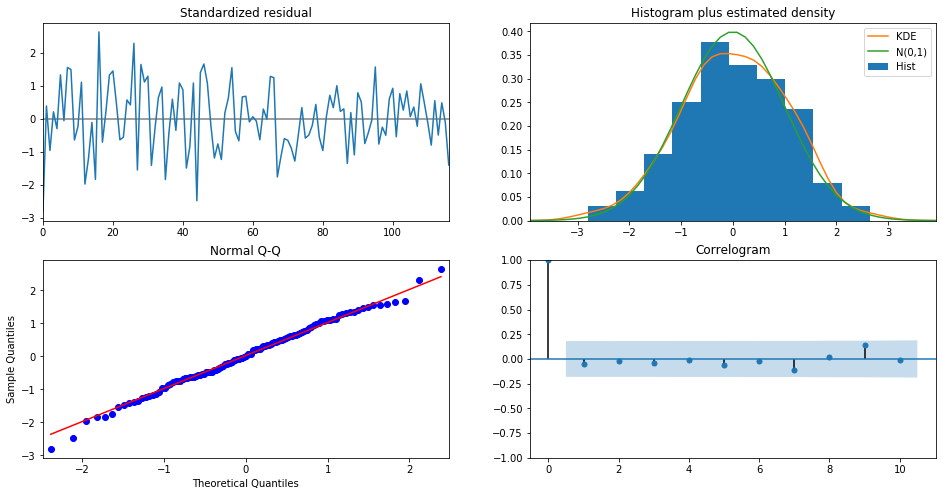

In [659]:
for model in model_dict:
    print(model)
    model_dict[model].plot_diagnostics(figsize=(16,8))
    plt.show()
    print()

Diagnostic looks okay for MBQ and Rebar.  Billets is a little suspect with what appears to be more residual variation on the left.  SBQ does not look good at all.  Signficant change in behavior starting around 2015.  Using data starting from 2015 diagnostics might look a little better, but there is much less data.

In [426]:
def forecast_test(model, actual, periods):
    # Forecast
    forecast, conf_50 = model.predict(n_periods=periods, return_conf_int=True, alpha=0.5)
    _, conf_95 = model.predict(n_periods=periods, return_conf_int=True, alpha=0.05)
    index_of_fc = pd.date_range(actual.index[0], periods=periods, freq='MS')
    
    # make dataframe for plotting
    forecast_df = pd.DataFrame(index=index_of_fc)
    forecast_df.index.name = 'month'
    forecast_df['kton'] = forecast
    forecast_df['lower_50'] = conf_50[:, 0]
    forecast_df['upper_50'] = conf_50[:, 1]
    forecast_df['lower_95'] = conf_95[:, 0]
    forecast_df['upper_95'] = conf_95[:, 1]
    forecast_df['actual'] = actual
    forecast_df['error'] = forecast_df.actual - forecast_df.kton
    
    return forecast_df

In [477]:
def plot_forecast_test(ax, df, history, actual, title):
    # Plot
    ax.set_ylabel('thousand tons')
    #ax.set_xlabel('month shipped')
    #ax.set_ylim(bottom=0, top='auto')
    ax.plot(history[-24:], label="history")
    ax.plot(actual, label="actual")
    ax.plot(df['kton'], color='k', alpha=.1, label="forecast")
    ax.fill_between(df.index, 
                     df['lower_50'], 
                     df['upper_50'], 
                     color='k',
                     alpha=.1,
                     label="50%")
    ax.fill_between(df.index, 
                     df['lower_95'], 
                     df['upper_95'], 
                     color='k',
                     alpha=.05,
                     label="95%")
    ax.legend()
    ax.set_title(title)

In [585]:
forecast = { }
for col in train_df.columns:
    forecast[col] = forecast_test(model_dict[col], test_df[col], 12)
    
#forecast['SBQ2015'] = forecast_test(model_dict['SBQ2015'], test_df['SBQ'], 12)
#forecast['Billets2015'] = forecast_test(model_dict['Billets2015'], test_df['Billets'], 12)
#forecast['total2013'] = forecast_test(model_dict['total2013'], test_df['total'], 12)

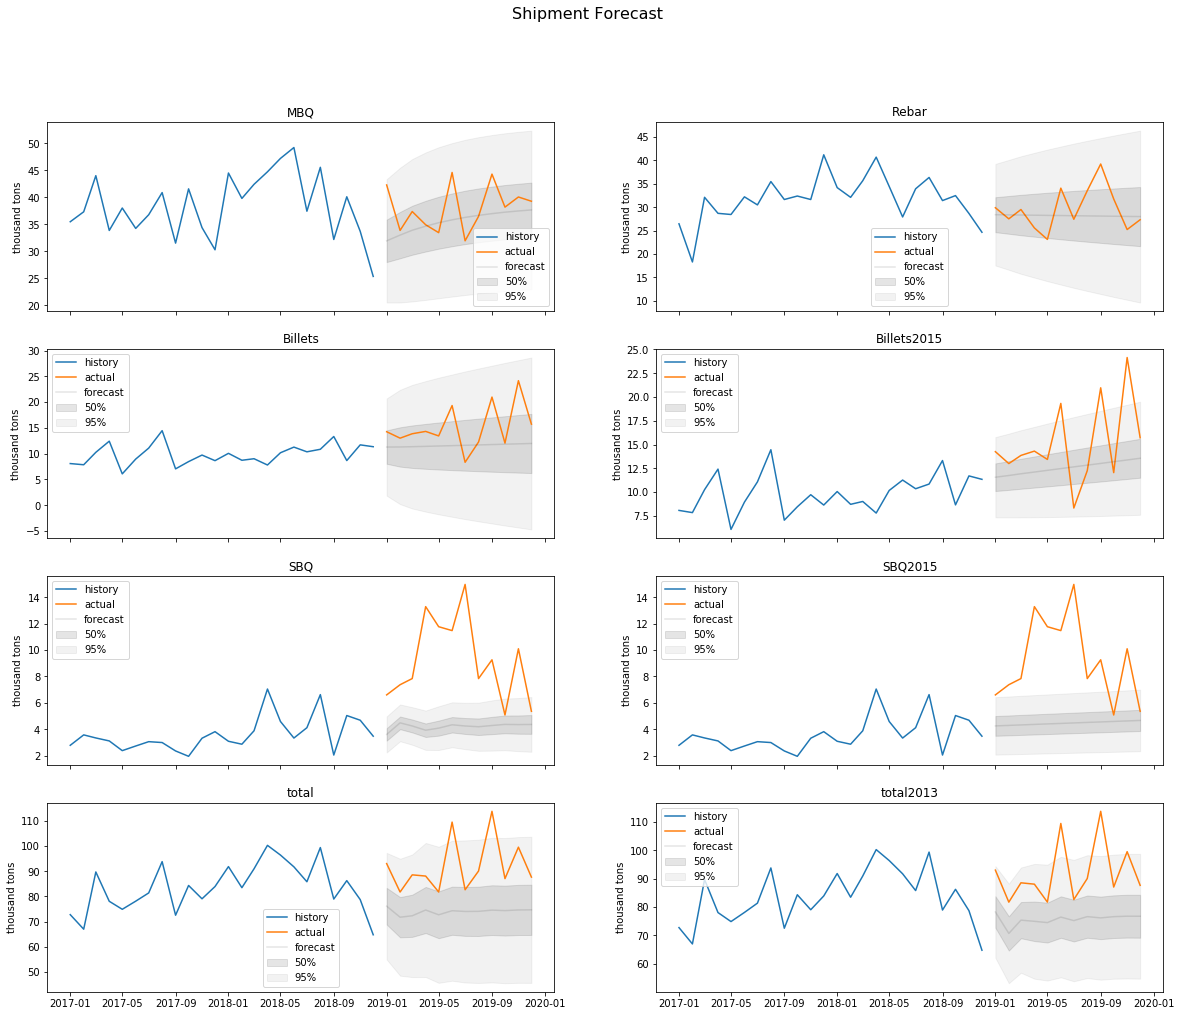

In [587]:
def plot_product_forecast(ax, product):
    plot_forecast_test(ax, forecast[product], train_df[product], test_df[product], product)

fig, axs = plt.subplots(4, 2, figsize=(20,16), sharex=True, sharey=False)

plot_product_forecast(axs[0,0], 'MBQ')
plot_product_forecast(axs[0,1], 'Rebar')
plot_product_forecast(axs[1,0], 'Billets')
plot_product_forecast(axs[1,1], 'Billets2015')
plot_product_forecast(axs[2,0], 'SBQ')
plot_product_forecast(axs[2,1], 'SBQ2015')
plot_product_forecast(axs[3,0], 'total')
plot_product_forecast(axs[3,1], 'total2013')

#axs[3,1].set_axis_off()
fig.suptitle('Shipment Forecast', fontsize=16)
plt.show()

Preliminarily MBQ and Rebar forecasts look reasonable.  Billets using data before 2015 has very large uncertainty (into negative values).  SBQ does not look great with or without pre-2015 data.  Total looks pretty good with or without pre-2013 data.

## Accuracy Metrics

Measure accuracy over a 3-month window

In [434]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape, 'mae':mae, 'rmse':rmse})

In [506]:
# display forecast data, and accuracy metrics
# compare to naive forecast
def quarterly_metrics(title, acc_forecast, index):
    print(title)
    #mbq_forecast[index]['naive'] = [shipments_df['MBQ'][(index-1):index][0]] * 3
    print(acc_forecast[index])
    print()
    print('forecast metrics')
    print(forecast_accuracy(acc_forecast[index].kton, acc_forecast[index].actual))
    print()
    print('naive metrics')
    print(forecast_accuracy(acc_forecast[index]['naive'], acc_forecast[index].actual))
    print()

In [549]:
def acc_metrics(acc_model_dict, name, title):
    # create MBQ forecast for each quarter including a naive forecast
    acc_forecast = { }
    acc_forecast[-12] = forecast_test(acc_model_dict[-12], shipments_df[name][-12:-9], 3)
    acc_forecast[-12]['naive'] = [shipments_df[name][-13:-12][0]] * 3
    acc_forecast[-9] = forecast_test(acc_model_dict[-9], shipments_df[name][-9:-6], 3)
    acc_forecast[-9]['naive'] = [shipments_df[name][-10:-9][0]] * 3
    acc_forecast[-6] = forecast_test(acc_model_dict[-6], shipments_df[name][-6:-3], 3)
    acc_forecast[-6]['naive'] = [shipments_df[name][-7:-6][0]] * 3
    acc_forecast[-3] = forecast_test(acc_model_dict[-3], shipments_df[name][-3:], 3)
    acc_forecast[-3]['naive'] = [shipments_df[name][-4:-3][0]] * 3
    
    fig, axs = plt.subplots(2, 2, figsize=(20,8))
    axs[0,0].plot(acc_forecast[-12].naive, linestyle='--', label='naive', color='grey')
    axs[0,1].plot(acc_forecast[-9].naive, linestyle='--', label='naive', color='grey')
    axs[1,0].plot(acc_forecast[-6].naive, linestyle='--', label='naive', color='grey')
    axs[1,1].plot(acc_forecast[-3].naive, linestyle='--', label='naive', color='grey')
    plot_forecast_test(axs[0,0], acc_forecast[-12], shipments_df[name][-21:-12], shipments_df[name][-12:-9], 'Q1')
    plot_forecast_test(axs[0,1], acc_forecast[-9], shipments_df[name][-18:-9], shipments_df[name][-9:-6], 'Q2')
    plot_forecast_test(axs[1,0], acc_forecast[-6], shipments_df[name][-15:-6], shipments_df[name][-6:-3], 'Q3')
    plot_forecast_test(axs[1,1], acc_forecast[-3], shipments_df[name][-12:-3], shipments_df[name][-3:], 'Q4')

    fig.suptitle(title, fontsize=16)
    plt.show()
    
    quarterly_metrics("First Quarter 2019", acc_forecast, -12)
    quarterly_metrics("Second Quarter 2019", acc_forecast, -9)
    quarterly_metrics("Third Quarter 2019", acc_forecast, -6)
    quarterly_metrics("Fourth Quarter 2019", acc_forecast, -3)

In [607]:
# train models (takes a few minutes)
start = time.time()
acc_model_dict = { }
for i in [-12, -9, -6, -3]:
    acc_model_dict[i] = pm.auto_arima(train_df['Billets2015'][:i].dropna(), m=1, seasonal=False, d=None, D=None,
                                      suppress_warnings=True, error_action='ignore')
    
elapsed = time.time() - start
print('Took %f seconds' % elapsed)
print('Model count: %d' % len(acc_model_dict))

Took 1.789040 seconds
Model count: 4


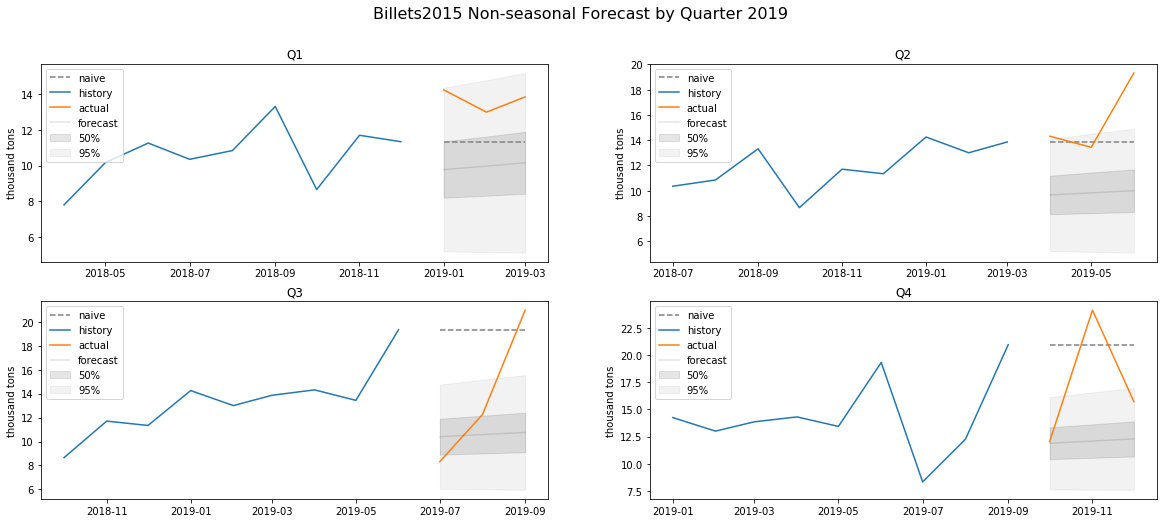

First Quarter 2019
                 kton  lower_50   upper_50  lower_95   upper_95     actual     error      naive
month                                                                                          
2019-01-01   9.778967  8.197609  11.360324  5.183782  14.374151  14.250438  4.471471  11.340379
2019-02-01   9.968561  8.308275  11.628848  5.144022  14.793101  12.999956  3.031395  11.340379
2019-03-01  10.158156  8.422526  11.893786  5.114681  15.201631  13.856726  3.698570  11.340379

forecast metrics
{'mape': 0.2712926586362257, 'mae': 3.7338121305263776, 'rmse': 3.7798955914592813}

naive metrics
{'mape': 0.17115537975255402, 'mae': 2.3619945000000016, 'rmse': 2.41899724999129}

Second Quarter 2019
                kton  lower_50   upper_50  lower_95   upper_95     actual     error      naive
month                                                                                         
2019-04-01  9.658439  8.130806  11.186071  5.219372  14.097505  14.310313  4.651874  13.85

In [608]:
acc_metrics(acc_model_dict, 'Billets', 'Billets2015 Non-seasonal Forecast by Quarter 2019')

In [612]:
total_model = model_dict['total']
total_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  129
Model:               SARIMAX(3, 0, 1)   Log Likelihood                -490.286
Date:                Thu, 09 Jan 2020   AIC                            992.571
Time:                        14:10:34   BIC                           1009.730
Sample:                             0   HQIC                           999.543
                                - 129                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     29.0434      9.650      3.010      0.003      10.130      47.956
ar.L1         -0.2076      0.170     -1.220      0.222      -0.541       0.126
ar.L2          0.4391      0.123      3.581      0.000       0.199       0.679
ar.L3          0.3820      0.079      4.840      0.000       0.227       0.537
ma.L1          0.6588      0.178      3.707      0.000       0.310       1.007
sigma2       116.2922     17.440      6.668      0.000      82.110     150.475
===================================================================================
Ljung-Box (Q):                       49.35   Jarque-Bera (JB):                 1.62
Prob(Q):                              0.15   Prob(JB):                         0.45
Heteroskedasticity (H):               0.42   Skew:                            -0.06
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.46
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [644]:
m = model_dict['total']
SARIMAX?

Object `SARIMAX` not found.


In [642]:
total_model.forecast?

Signature: total_model.forecast(steps=1, exog=None, alpha=0.05)
Docstring:
Out-of-sample forecasts

Parameters
----------
steps : int
    The number of out of sample forecasts from the end of the
    sample.
exog : array
    If the model is an ARMAX, you must provide out of sample
    values for the exogenous variables. This should not include
    the constant.
alpha : float
    The confidence intervals for the forecasts are (1 - alpha) %

Returns
-------
forecast : array
    Array of out of sample forecasts
stderr : array
    Array of the standard error of the forecasts.
conf_int : array
    2d array of the confidence interval for the forecast
File:      c:\users\chad.hodnett\appdata\local\continuum\anaconda3\lib\site-packages\statsmodels\tsa\arima_model.py
Type:      method


In [617]:
total_arima = ARIMA(endog=train_df['total'], order=(3,0,1))
total_model = total_arima.fit(disp=0)

C:\Users\chad.hodnett\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [619]:
total_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  total   No. Observations:                  129
Model:                     ARMA(3, 1)   Log Likelihood                -490.286
Method:                       css-mle   S.D. of innovations             10.784
Date:                Thu, 09 Jan 2020   AIC                            992.571
Time:                        14:15:29   BIC                           1009.730
Sample:                    04-01-2008   HQIC                           999.543
                         - 12-01-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          75.1301      3.928     19.129      0.000      67.432      82.828
ar.L1.total    -0.2077      0.174     -1.196      0.234      -0.548       0.133
ar.L2.total     0.4390      0.119      3.700      0.000       0.206       0.672
ar.L3.total     0.3820      0.083      4.629      0.000       0.220       0.544
ma.L1.total     0.6588      0.177      3.718      0.000       0.311       1.006
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1825           -0.0000j            1.1825           -0.0000
AR.2           -1.1660           -0.9243j            1.4879           -0.3933
AR.3           -1.1660           +0.9243j            1.4879            0.3933
MA.1           -1.5178           +0.0000j            1.5178            0.5000
-----------------------------------------------------------------------------
"""

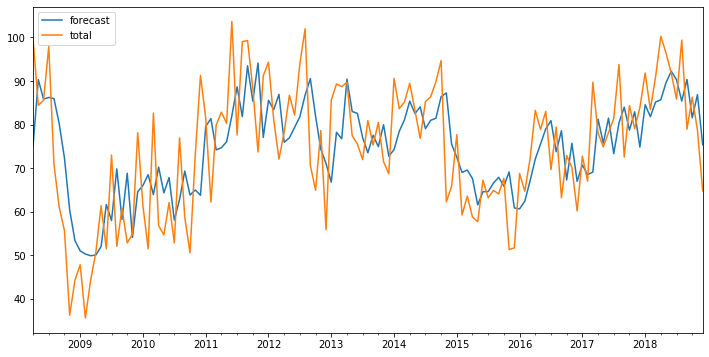

In [634]:
plt.rc('figure',figsize=(12,6))
fig = total_model.plot_predict(dynamic=False)
plt.show()

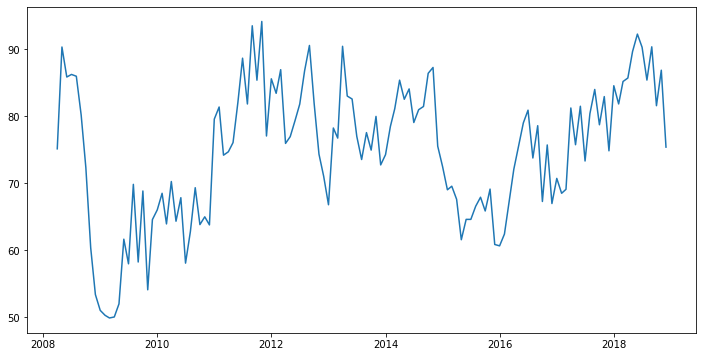

In [636]:
plt.plot(total_model.fittedvalues)

In [ ]:
train_df.index = pd.DatetimeIndex(train_df.index.values, freq='MS')

SARIMAX(3, 0, 1)x(1, 1, 1, 12)

In [751]:
sarima_model = SARIMAX(endog=shipments_df['total'].dropna(),
                       order=(1,0,1),
                       seasonal_order=(1,1,1,12))
sarima_result = sarima_model.fit(maxiter=200)

C:\Users\chad.hodnett\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


In [752]:
print(sarima_result.summary())
print(sarima_result.mle_retvals)

                                 Statespace Model Results                                 
Dep. Variable:                              total   No. Observations:                  141
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 12)   Log Likelihood                -503.821
Date:                            Thu, 09 Jan 2020   AIC                           1017.643
Time:                                    15:46:55   BIC                           1031.942
Sample:                                04-01-2008   HQIC                          1023.453
                                     - 12-01-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9245      0.062     14.904      0.000       0.803       1.046
ma.L1         -0.5087      0.106   

In [773]:
# In-sample one-step-ahead predictions
predict = sarima_result.get_prediction()
predict_ci = predict.conf_int()

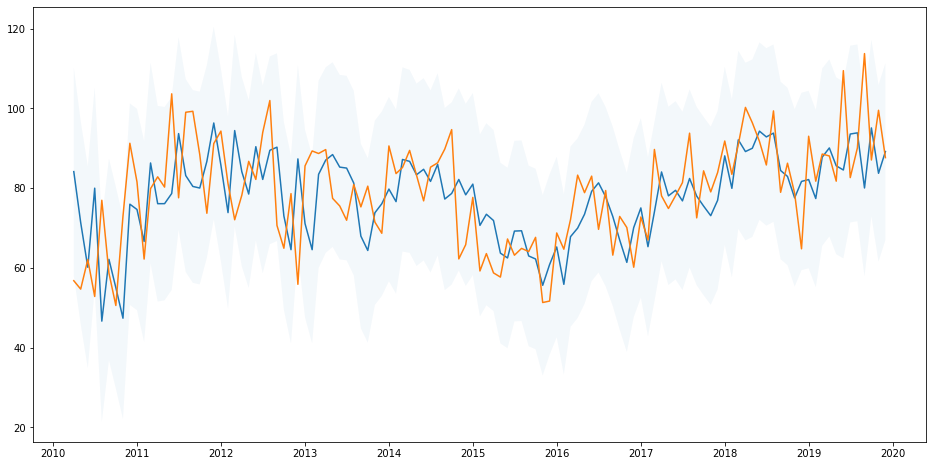

In [782]:
fig, ax = plt.subplots(figsize=(16,8))
plt.plot(predict.predicted_mean[24:])
plt.plot(shipments_df['total'][24:])
ci = predict_ci[24:]
ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.05)
plt.show()